本笔记本为[教材](http://manipulation.csail.mit.edu/robot.html)配套示例。建议将两个窗口并排打开！

In [1]:
import numpy as np
from pydrake.all import (
    AddMultibodyPlantSceneGraph,
    DiagramBuilder,
    InverseDynamicsController,
    MeshcatVisualizer,
    MultibodyPlant,
    Parser,
    Simulator,
    StartMeshcat,
    # ... 其他需要的模块 ...
)

from manipulation import running_as_notebook
from manipulation.utils import RenderDiagram  # 渲染系统结构图

In [ ]:
# 启动可视化工具 Meshcat。
meshcat = StartMeshcat()

INFO:drake:Meshcat listening for connections at http://localhost:7001


# 使用方块图进行仿真

在本章以及后续内容中，我们将使用 Drake 的方块图建模语言（称为“系统框架”）来搭建仿真和控制器。[本教程](https://deepnote.com/workspace/Drake-0b3b2c53-a7ad-441b-80f8-bf8350752305/project/Tutorials-2b4fc509-aef2-417d-a40d-6071dfed9199/notebook/dynamical_systems-51e3befa8950475d88002fce5d910abf)有简要介绍。

# 仿真（无控制）的 iiwa 机械臂

让我们把选定的机器人（Kuka iiwa）加载到物理引擎中，这个引擎在 Drake 中叫做 [MultibodyPlant](https://drake.mit.edu/doxygen_cxx/classdrake_1_1multibody_1_1_multibody_plant.html)。

In [ ]:
plant = MultibodyPlant(time_step=1e-4)
Parser(plant).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf" # 加载 iiwa 机械臂模型
    )
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0")) # 固定底座
plant.Finalize() # 完成模型构建

在 Drake 中，我们非常注意将系统的*状态*与系统本身分离。例如，可以将动力系统表示为差分方程：$$x[n+1] = f(n, x[n], u[n])$$，其中 $n$ 是“时间”，$x$ 是状态，$u$ 是输入。`System` 描述 $f()$，但我们用一个叫 [`Context`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_context.html) 的结构体来保存运行时的值：$n, x, u$。之所以用结构体，是因为有些系统有更多运行时参数，比如系统参数、随机噪声输入等，用结构体传递比每个系统都接受不同参数列表更清晰。原则上，`System` 在仿真期间是常量，只要给定相同的 `Context`，仿真结果应当是可重复、确定的。
让我们看看现在加载了 iiwa 后，物理引擎的 `Context` 是什么样的。

In [4]:
context = plant.CreateDefaultContext()
print(context)  # 打印当前 context 信息

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       100
     1 parameters
       4.54e-05
     1 parameters
       160
     1 parameters
       4.54e-05
     1 parameters
       160
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
                          5                 -0.1                

系统有 14 个状态变量——对应 iiwa 的 7 个关节位置和 7 个关节速度。这些状态是离散的，因为我们在 `MultibodyPlant` 构造函数中传入了非零的 `time_step`，这意味着物理引擎会采用时间步进仿真方案（后续模拟接触时性能更好）。你可以尝试把 `time_step` 改为 0，看看会发生什么。
你会注意到 context 里有很多参数（目前包括每个刚体的质量、质心和惯性）。这些参数暂时用不到，但它们支持一些很酷的高级功能。
由于 `MultibodyPlant` 的 `Context` 可能很复杂，`MultibodyPlant` 提供了一些方法帮助你获取/设置这些值。让我们设置一些非零的初始关节位置。

In [5]:
# 一次性设置所有关节的位置。
plant.SetPositions(context, [-1.57, 0.1, 0, 0, 0, 1.6, 0])
# 也可以通过关节名称单独设置某个关节。
plant.GetJointByName("iiwa_joint_4").set_angle(context, -1.2)
print(context)  # 打印 context 信息

::_ Context
------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       100
     1 parameters
       4.54e-05
     1 parameters
       160
     1 parameters
       4.54e-05
     1 parameters
       160
     10 parameters
       nan nan nan nan nan nan nan nan nan nan
     10 parameters
        

iiwa 模型还定义了 7 个执行器。在运行仿真前，我们需要为 `MultibodyPlant` 的 `actuation_input_port` 输入一些值。这里我们先全部设为零。

In [6]:
plant.get_actuation_input_port().FixValue(context, np.zeros(7))  # 所有执行器输入设为 0

现在我们可以设置并运行仿真了。

In [7]:
simulator = Simulator(plant, context)
simulator.AdvanceTo(5.0)  # 仿真 5 秒
print(context)  # 打印仿真后 context 信息

::_ Context
------------
Time: 5
States:
  1 discrete state groups with
     14 states
           -1.609700367281347      2.094395102449683   0.006230121798167454    -0.1058825758499597    0.08793602547285667    -0.6812074370294305 -0.0001115867900088022  -0.002068091894079937 -2.468846932083886e-12     0.1884289549825827    -0.4224407792746285     0.1147954715844053     0.9972587721309389 -0.0001923350279603112
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 par

# 场景可视化

物理引擎结果的最佳可视化方式是用 2D 或 3D 可视化工具。为此，我们需要添加一个管理场景几何体的系统（几何引擎）；在 Drake 中叫做 [`SceneGraph`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1geometry_1_1_scene_graph.html)。有了 `SceneGraph`，就可以添加各种可视化器和传感器来渲染场景。

Drake 支持多种可视化器（官方二进制包自带简单的 VTK "drake-visualizer"，也可以用 RViz）。但因为我们在 Jupyter 笔记本中操作，并希望你能在任何机器上运行 3D 图形而无需额外安装，这里我们全程使用 [MeshCat](https://github.com/rdeits/meshcat) 可视化器。

要同时使用 `MultibodyPlant`、`SceneGraph` 和 `MeshcatVisualizer`，需要用 [`DiagramBuilder`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram_builder.html) 组装成一个 [`Diagram`](https://drake.mit.edu/doxygen_cxx/classdrake_1_1systems_1_1_diagram.html)。通常你会分别添加每个系统并连接端口，但像这里这种常见场景，我们提供了简化的辅助方法。

In [8]:
meshcat.Delete()
meshcat.DeleteAddedControls()
builder = DiagramBuilder()
# 同时添加 MultibodyPlant 和 SceneGraph，并自动连接。
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# 注意这里模型会被同时解析到 plant 和 scene_graph。
Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf" # 加载 iiwa 模型
)
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0")) # 固定底座
plant.Finalize()
# 添加 MeshcatVisualizer 并连接到 SceneGraph。
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
diagram = builder.Build()
diagram.set_name("plant and scene_graph")

如果你点击上面的链接，可以在浏览器窗口中看到可视化效果。

但目前场景还是空的。我们需要真正构建 diagram 并让它发布一次。（通常你不用手动调用这些；MeshcatVisualizer 会在初始化时自动加载，并在仿真期间定期发布。）

In [9]:
context = diagram.CreateDefaultContext()
diagram.ForcedPublish(context)  # 强制发布一次场景

现在我们已经组装了一个相当复杂的系统。`Diagram` 其实也是一个 `System`，因此也有自己的 context。

In [10]:
print(context)  # 打印 diagram 的 context

::plant and scene_graph Context (of a Diagram)
-----------------------------------------------
14 total discrete states in 1 groups
1 total abstract states
291 total numeric parameters in 46 groups
13 total abstract parameters

::plant and scene_graph::plant Context
---------------------------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       0 0 0 0 0 0 0 0 0 0 0 0 0 0
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
    

画出实际的方块图也很有用。

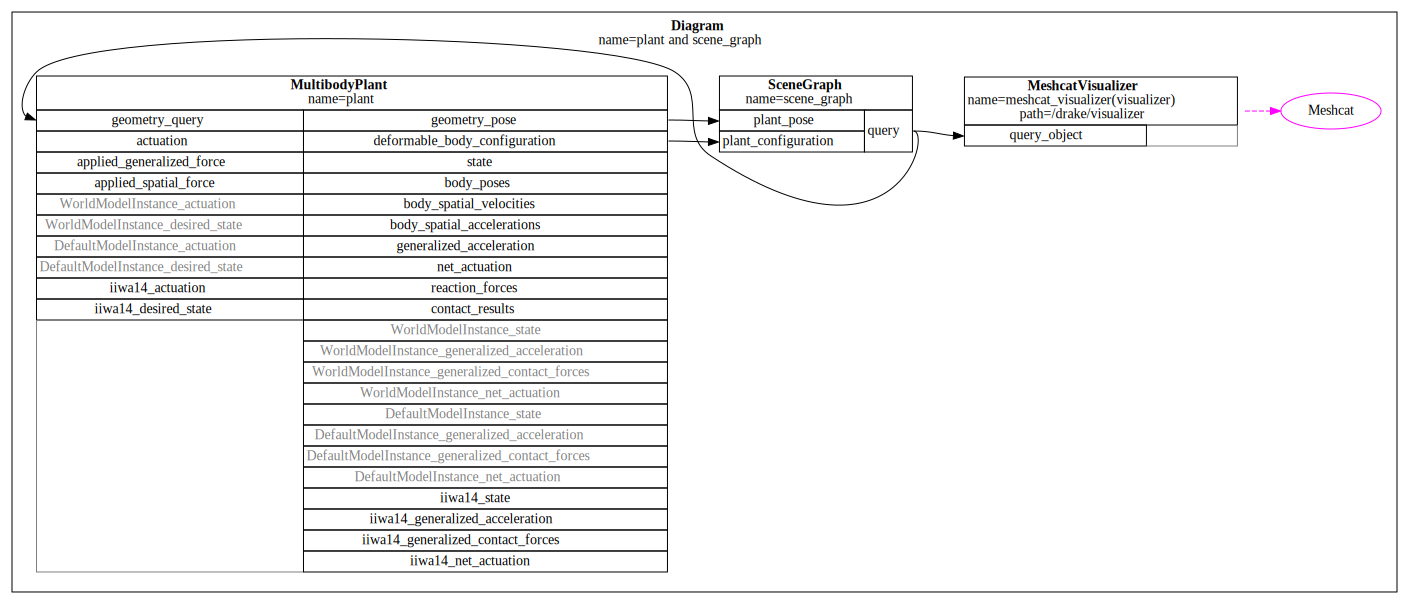

In [11]:
RenderDiagram(diagram)  # 渲染系统结构图

还有一个重要细节：**`Diagram` 的 `Context` 不是 `MultibodyPlant` 的 `Context`。但你可以提取出 plant 的 `Context`；我们需要这样做来设置机器人的初始条件。

In [12]:
plant_context = plant.GetMyMutableContextFromRoot(context)
plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])  # 设置初始关节位置
plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))  # 执行器输入设为 0
print(context)  # 打印 context

::plant and scene_graph Context (of a Diagram)
-----------------------------------------------
14 total discrete states in 1 groups
1 total abstract states
291 total numeric parameters in 46 groups
13 total abstract parameters

::plant and scene_graph::plant Context
---------------------------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
 

不小心用 `context` 替代 `plant_context` 是非常常见的错误！

好了，现在我们可以仿真了。确保你的可视化窗口可见，然后运行下面的单元格。

In [13]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)  # 实时速率为 1
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)  # 仿真 5 秒（notebook 环境），否则 0.1 秒

太棒了！

还有一个小技巧。你可以让 MeshCat 录制动画，然后在可视化窗口用滑块回放。

我会在这里重复前面的准备代码，使本单元格可独立运行。（而且同一个系统不能被多次用于不同 diagram，所有权有限制。）

In [14]:
def animation_demo():
    builder = DiagramBuilder()
    # 同时添加 MultibodyPlant 和 SceneGraph，并自动连接。
    plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
    # 注意这里模型会被同时解析到 plant 和 scene_graph。
    Parser(plant, scene_graph).AddModelsFromUrl(
        "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf" # 加载 iiwa 模型
    )
    plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0")) # 固定底座
    plant.Finalize()
    # 添加 MeshcatVisualizer 并连接到 SceneGraph。
    MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
    diagram = builder.Build()
    context = diagram.CreateDefaultContext()
    plant_context = plant.GetMyMutableContextFromRoot(context)
    plant.SetPositions(plant_context, [-1.57, 0.1, 0, -1.2, 0, 1.6, 0])  # 设置初始关节位置
    plant.get_actuation_input_port().FixValue(plant_context, np.zeros(7))  # 执行器输入设为 0
    simulator = Simulator(diagram, context)
    simulator.set_target_realtime_rate(1.0)
    meshcat.StartRecording()  # 开始录制动画
    simulator.AdvanceTo(5.0 if running_as_notebook else 0.1)
    meshcat.StopRecording()   # 停止录制
    meshcat.PublishRecording()  # 发布动画

animation_demo()  # 运行动画演示

# 添加 iiwa 控制器

iiwa 的硬件接口自带厂家提供的控制系统，无法关闭。我们能做的最好办法是在仿真中添加一个近似的控制器。下面会重复前面的搭建过程（保证本例自洽），但会多加一个控制器系统。

In [15]:
builder = DiagramBuilder()
# 同时添加 MultibodyPlant 和 SceneGraph，并自动连接。
plant, scene_graph = AddMultibodyPlantSceneGraph(builder, time_step=1e-4)
# 注意这里模型会被同时解析到 plant 和 scene_graph。
iiwa_model = Parser(plant, scene_graph).AddModelsFromUrl(
    "package://drake_models/iiwa_description/sdf/iiwa14_no_collision.sdf" # 加载 iiwa 模型
)[0]
plant.WeldFrames(plant.world_frame(), plant.GetFrameByName("iiwa_link_0")) # 固定底座
plant.Finalize()
# 添加 MeshcatVisualizer 并连接到 SceneGraph。
visualizer = MeshcatVisualizer.AddToBuilder(builder, scene_graph, meshcat)
# 添加 iiwa 控制器的近似实现。
# TODO(russt): 用关节阻抗控制器替换本实现。
kp = [100] * plant.num_positions()
ki = [1] * plant.num_positions()
kd = [20] * plant.num_positions()
iiwa_controller = builder.AddSystem(InverseDynamicsController(plant, kp, ki, kd, False))
iiwa_controller.set_name("iiwa_controller")
builder.Connect(
    plant.get_state_output_port(iiwa_model),
    iiwa_controller.get_input_port_estimated_state(),
)
builder.Connect(
    iiwa_controller.get_output_port_control(), plant.get_actuation_input_port()
)
diagram = builder.Build()
diagram.set_name("with iiwa controller")

让我们看看方块图长什么样……

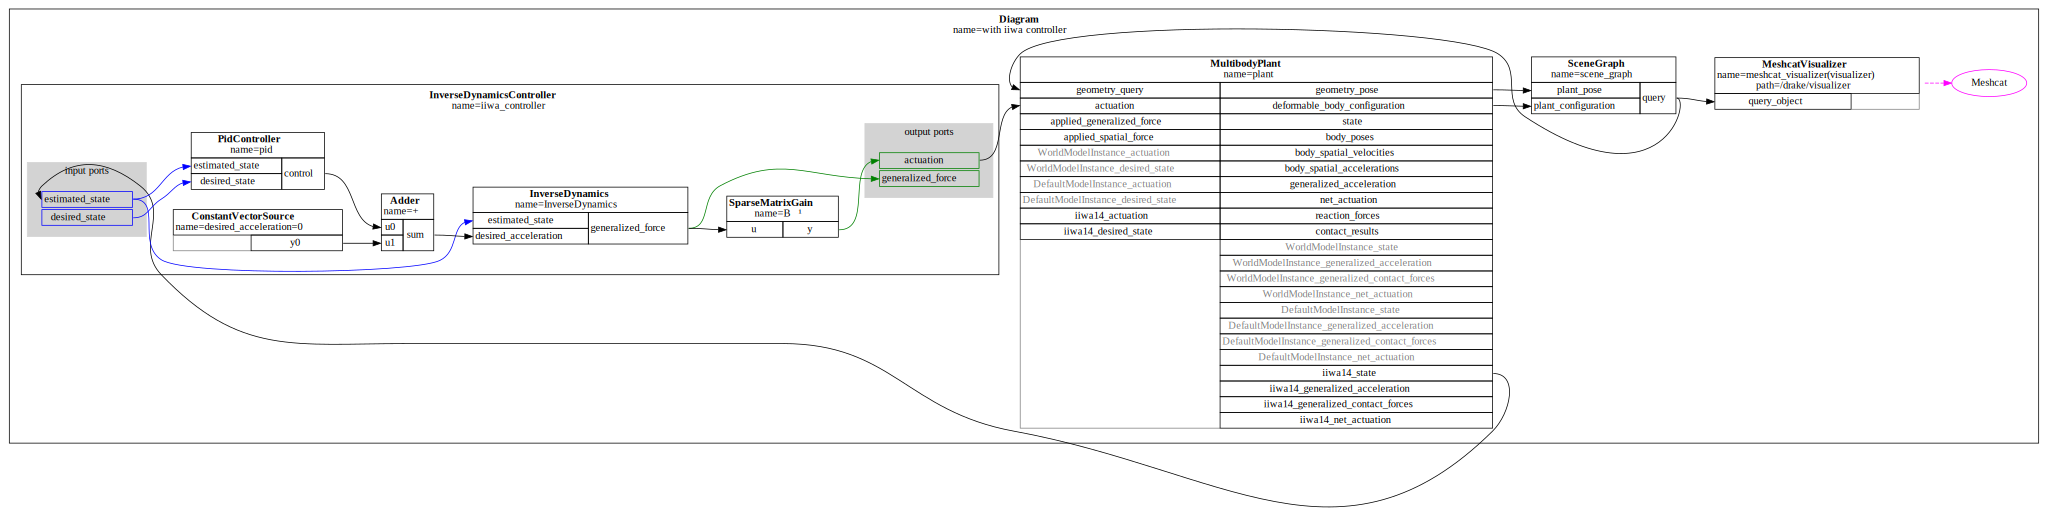

In [16]:
RenderDiagram(diagram)  # 渲染系统结构图

随着方块图变得更复杂，你可以给 `RenderDiagram` 方法传递 `max_depth` 参数。

TODO(russt): 更新为 javascript 渲染 [#13874](https://github.com/RobotLocomotion/drake/issues/13874)。

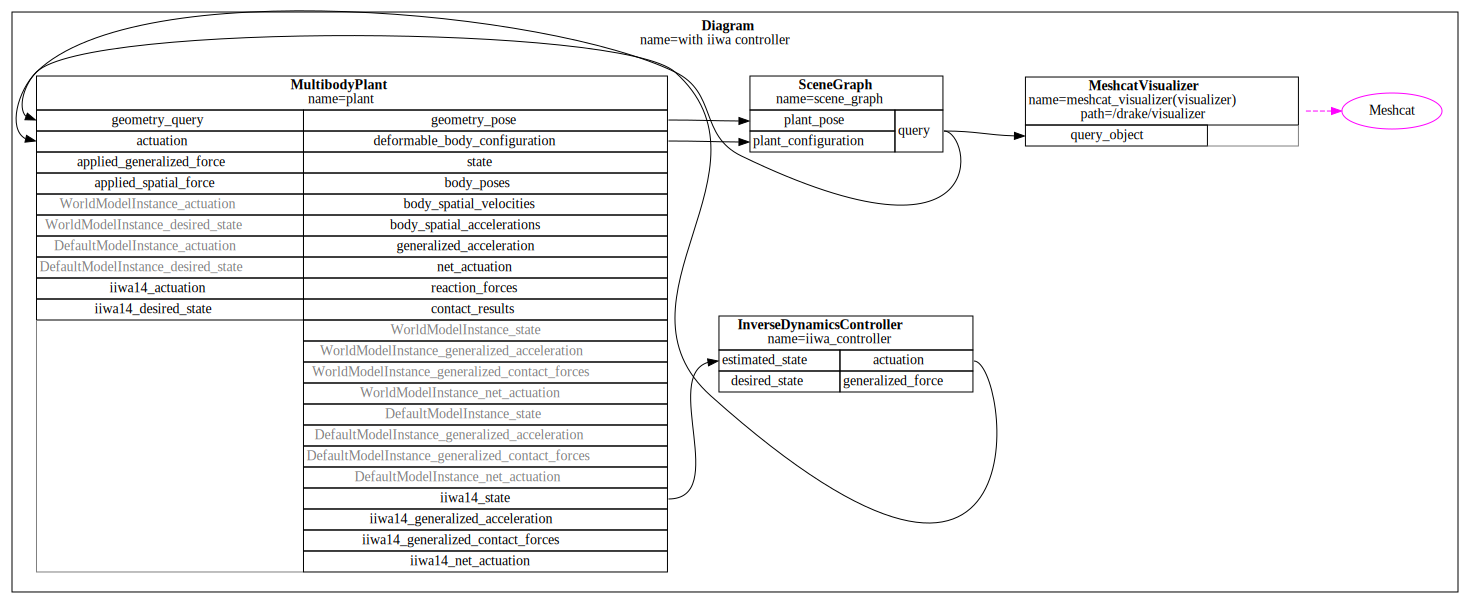

In [17]:
RenderDiagram(diagram, max_depth=1)  # 只显示一层结构

现在要设置 `Context`，不再是把 `actuation_input` 设为零，而是把 iiwa 控制器的 `desired_state` 设为当前机械臂位置。注意，期望*状态*还要包括期望速度，这里设为零。

In [18]:
context = diagram.CreateDefaultContext()
plant_context = plant.GetMyMutableContextFromRoot(context)
q0 = np.array([-1.57, 0.1, 0, -1.2, 0, 1.6, 0])
x0 = np.hstack((q0, 0 * q0))  # 期望状态 = 期望位置 + 期望速度（全 0）
plant.SetPositions(plant_context, q0)
iiwa_controller.GetInputPort("desired_state").FixValue(
    iiwa_controller.GetMyMutableContextFromRoot(context), x0
)
print(context)  # 打印 context

::with iiwa controller Context (of a Diagram)
----------------------------------------------
7 total continuous states
14 total discrete states in 1 groups
1 total abstract states
298 total numeric parameters in 47 groups
13 total abstract parameters

::with iiwa controller::plant Context
--------------------------------------
Time: 0
States:
  1 discrete state groups with
     14 states
       -1.57   0.1     0  -1.2     0   1.6     0     0     0     0     0     0     0     0
  1 abstract states

Parameters:
  46 numeric parameter groups with
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     1 parameters
       0
     0 parameters
       
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 parameters
       160
     1 parameters
       0.0001321
     1 p

现在仿真时，机械臂会保持静止。和真实机器人一样。

In [19]:
simulator = Simulator(diagram, context)
simulator.set_target_realtime_rate(1.0)  # 实时速率为 1
simulator.AdvanceTo(5.0 if running_as_notebook else 0.1);  # 仿真 5 秒（notebook 环境），否则 0.1 秒

In [20]:
# （本单元格留空，可用于后续扩展）